In [118]:
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import cvxpy as cp
import networkx as nx
from sklearn.linear_model import lasso_path, Lasso
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV
from random import shuffle

In [2]:
us_swap_df = pd.read_csv("USSwap.csv")
us_swap_df['Date'] = pd.to_datetime(us_swap_df['Date'])
us_swap_df.set_index('Date', inplace=True)
us_swap_df.fillna(method="ffill", inplace=True)

# demeaned to match the assumption, as LASSO does not need
us_swap_df_demeaned = us_swap_df - us_swap_df.mean(axis=0)

In [3]:
us_swap_df_shifted = us_swap_df_demeaned.shift(1).dropna()

## LASSO estimate of $A$

In [4]:
alpha_candidate = []
for instr in us_swap_df_shifted.columns:
    dep_var = us_swap_df_demeaned[instr].loc[us_swap_df_shifted.index]
    endog_var = us_swap_df_shifted
    alphas_lasso, coefs_lasso, _ = lasso_path(endog_var, dep_var, eps=1e-4)
    non_zeros = np.count_nonzero(coefs_lasso, axis=0)
    best_alpha = alphas_lasso[((non_zeros <= 6) & (non_zeros >= 4)).argmax().min()]
    alpha_candidate.append(best_alpha)
    
print(np.array(alpha_candidate).max())
print(np.array(alpha_candidate).min())

0.005566343201245493
0.0001333368280870626


In [5]:
alpha1 = np.array(alpha_candidate).max()
alpha2 = np.array(alpha_candidate).min()

In [63]:
for alpha_ in np.logspace(-3, -4.2, 100):
    coef_list = []
    for instr in us_swap_df_shifted.columns:
        dep_var = us_swap_df_demeaned[instr].loc[us_swap_df_shifted.index]
        endog_var = us_swap_df_shifted
        lasso_model = Lasso(alpha=alpha_, fit_intercept=False, max_iter=10000)
        coefs_lasso = lasso_model.fit(endog_var, dep_var).coef_
        coef_list.append(coefs_lasso)
        
    Ahat = np.vstack(tuple(coef_list))
    non_zeros = np.count_nonzero(Ahat)
    
    if non_zeros == 40:
        print(alpha_)
        break
        
Ahat

0.00016758780942343246


array([[ 9.49322503e-01,  8.74181802e-02, -0.00000000e+00,
        -2.52104544e-02, -1.20459592e-02, -3.87917279e-03,
        -0.00000000e+00, -0.00000000e+00],
       [ 4.44063065e-02,  8.83379898e-01,  7.86708937e-02,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -1.01664690e-02],
       [-5.33757473e-02,  3.49064602e-01,  4.36122970e-01,
         1.99617259e-01,  7.19642544e-02,  0.00000000e+00,
        -0.00000000e+00, -2.81803023e-03],
       [-2.18709585e-02,  0.00000000e+00,  4.10986410e-01,
         3.26984937e-01,  1.87319916e-01,  9.54720910e-02,
         0.00000000e+00, -0.00000000e+00],
       [-4.61488752e-03, -0.00000000e+00,  5.97363862e-03,
         3.44543296e-01,  4.23081498e-01,  2.29765053e-01,
         0.00000000e+00,  0.00000000e+00],
       [-1.14881531e-02, -0.00000000e+00,  0.00000000e+00,
         3.42718709e-03,  3.41652582e-01,  4.00938902e-01,
         2.23306819e-01,  4.47676413e-02],
       [-7.94200001e-03, -0.000000

## Graphical LASSO estimate of $\Gamma$

In [9]:
us_swap_df_demeaned.shape

(2087, 8)

In [61]:
edge_model = GraphicalLasso(alpha=2, max_iter=1000)

edge_model.fit(us_swap_df_demeaned)
edge_model.precision_

array([[ 0.34714071, -0.12157042, -0.09115941, -0.06954562, -0.04812054,
        -0.        , -0.        , -0.        ],
       [-0.12157042,  0.41121113, -0.05535139, -0.02797636, -0.        ,
        -0.        , -0.        , -0.        ],
       [-0.09115941, -0.05535139,  0.48251996, -0.        , -0.        ,
        -0.        , -0.        , -0.        ],
       [-0.06954562, -0.02797636, -0.        ,  0.55478407, -0.        ,
        -0.        , -0.        , -0.        ],
       [-0.04812054, -0.        , -0.        , -0.        ,  0.63485065,
        -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
         0.80801043, -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ,  1.0405434 , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        ,  1.74443359]])

In [53]:
gamma = np.linalg.inv(edge_model.precision_)

In [54]:
gamma

array([[3.67617536, 1.23496842, 0.8361834 , 0.52310766, 0.27864751,
        0.        , 0.        , 0.        ],
       [1.23496842, 2.89349014, 0.56523608, 0.30072232, 0.0936084 ,
        0.        , 0.        , 0.        ],
       [0.8361834 , 0.56523608, 2.29526791, 0.13332419, 0.0633812 ,
        0.        , 0.        , 0.        ],
       [0.52310766, 0.30072232, 0.13332419, 1.88324254, 0.03965062,
        0.        , 0.        , 0.        ],
       [0.27864751, 0.0936084 , 0.0633812 , 0.03965062, 1.59629462,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.23760779, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.96103632, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.57325197]])

In [55]:
edge_model.covariance_

array([[3.67616443, 1.23496486, 0.83618093, 0.52310611, 0.27864668,
        0.        , 0.        , 0.        ],
       [1.23496486, 2.89348782, 0.56523514, 0.30072176, 0.09360813,
        0.        , 0.        , 0.        ],
       [0.83618093, 0.56523514, 2.29526614, 0.13332383, 0.06338102,
        0.        , 0.        , 0.        ],
       [0.52310611, 0.30072176, 0.13332383, 1.88324165, 0.03965051,
        0.        , 0.        , 0.        ],
       [0.27864668, 0.09360813, 0.06338102, 0.03965051, 1.59629455,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.23760779, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.96103632, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.57325197]])

In [56]:
pd.DataFrame(edge_model.precision_)

,0,1,2,3,4,5,6,7
0,0.347141,-0.121570,-0.091159,-0.069546,-0.048121,-0.00000,-0.000000,-0.000000
1,-0.121570,0.411211,-0.055351,-0.027976,-0.000000,-0.00000,-0.000000,-0.000000
2,-0.091159,-0.055351,0.482520,-0.000000,-0.000000,-0.00000,-0.000000,-0.000000
3,-0.069546,-0.027976,-0.000000,0.554784,-0.000000,-0.00000,-0.000000,-0.000000
4,-0.048121,-0.000000,-0.000000,-0.000000,0.634851,-0.00000,-0.000000,-0.000000
5,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.80801,-0.000000,-0.000000
6,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,1.040543,-0.000000
7,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,1.744434


In [57]:
graph = nx.from_numpy_array(edge_model.precision_)

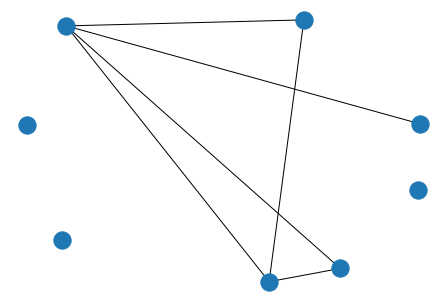

In [58]:
nx.draw(graph)

## Greedy algorithm

In [66]:
A = Ahat.T @ gamma @ Ahat
B = gamma

In [95]:
test_eigh = scipy.linalg.eigh(A, B)

In [97]:
test_eigh

(array([5.99497892e-04, 2.74749504e-02, 1.93520485e-01, 4.27011603e-01,
        7.03683532e-01, 9.16725815e-01, 1.07616882e+00, 1.14056309e+00]),
 array([[-2.81410005e-04,  3.68076639e-03,  2.78559348e-02,
         -8.03306303e-02,  2.81318561e-01, -4.94418881e-01,
         -9.03803687e-02, -9.02183340e-02],
        [-9.84324306e-03,  4.06351983e-02, -1.47712596e-01,
          1.95982025e-01, -2.94145530e-01,  1.22507523e-01,
          3.67883249e-02, -4.96338584e-01],
        [ 5.25611798e-02, -3.18919842e-01,  4.72304396e-01,
         -2.72416227e-01,  6.37301624e-04,  2.56480341e-01,
          7.70383957e-02, -9.51203913e-02],
        [-2.25229190e-01,  5.49301145e-01,  4.75669569e-02,
         -3.06592369e-01,  1.45902203e-01,  2.69268644e-01,
          1.02572588e-01, -4.18144015e-02],
        [ 5.10309674e-01, -8.72902980e-02, -3.84913339e-01,
         -1.51303410e-01,  3.09908915e-01,  2.57547376e-01,
          1.68772258e-01, -7.00415895e-02],
        [-5.83250858e-01, -3.54736

In [96]:
test_eigh[1][-1, :]

array([-0.00634316, -0.01100328, -0.06903778, -0.25132225, -0.42199637,
       -0.43728089,  1.13380694,  0.14672933])

In [123]:
col_row_list = []
candidate_list = set(range(A.shape[0]))
designated_k = 5
for num in range(designated_k):
    # num is the length of support we're considering
    print(col_row_list)
    max_gen_eig_ratio = np.NINF
    seq = list(candidate_list)
    shuffle(seq)
    for support in seq:
        cand = col_row_list + [support]
        left_matrix = A[cand, :][:, cand]
        print(left_matrix)
        right_matrix = B[cand, :][:, cand]
        print(right_matrix)
        if len(cand) == 1:
            left_matrix = left_matrix.reshape(-1, 1)
            right_matrix = right_matrix.reshape(-1, 1)

        eigval, eigvec = scipy.linalg.eigh(left_matrix, right_matrix)
        
        x = np.zeros((A.shape[0], ))
        x[cand] = eigvec[-1, :]
        x = x.reshape(-1, 1)
        
        gen_eig_ratio = np.squeeze((x.T @ A @ x) / (x.T @ B @ x))
        if gen_eig_ratio > max_gen_eig_ratio:
            max_gen_eig_ratio = gen_eig_ratio
            cur_support = support
    col_row_list.append(cur_support)
    candidate_list.remove(cur_support)
        
print(col_row_list)

[]
[[3.31868863]]
[[3.67617536]]
[[0.87927083]]
[[2.29526791]]
[[0.39721995]]
[[0.96103632]]
[[3.15608391]]
[[2.89349014]]
[[0.37209976]]
[[1.23760779]]
[[0.51578408]]
[[1.59629462]]
[[0.57064199]]
[[0.57325197]]
[[0.49784105]]
[[1.88324254]]
[1]
[[ 3.15608391e+00 -3.93619405e-07]
 [-3.93619405e-07  3.97219949e-01]]
[[2.89349014 0.        ]
 [0.         0.96103632]]
[[3.15608391 1.66314723]
 [1.66314723 3.31868863]]
[[2.89349014 1.23496842]
 [1.23496842 3.67617536]]
[[ 3.15608391 -0.03297924]
 [-0.03297924  0.57064199]]
[[2.89349014 0.        ]
 [0.         0.57325197]]
[[3.15608391 0.20001935]
 [0.20001935 0.51578408]]
[[2.89349014 0.0936084 ]
 [0.0936084  1.59629462]]
[[3.15608391 0.39277408]
 [0.39277408 0.49784105]]
[[2.89349014 0.30072232]
 [0.30072232 1.88324254]]
[[3.15608391 0.97203798]
 [0.97203798 0.87927083]]
[[2.89349014 0.56523608]
 [0.56523608 2.29526791]]
[[3.15608391 0.05724035]
 [0.05724035 0.37209976]]
[[2.89349014 0.        ]
 [0.         1.23760779]]
[1, 0]
[[3.1560

## SDP

In [146]:
X_dim = B.shape[0]
X = cp.Variable((X_dim, X_dim), symmetric=True)

In [147]:
card = 5

constraints = [
    cp.sum(cp.abs(X)) <= card * cp.trace(X),
    cp.trace(B @ X) == 1,
    X >> 0
]

In [148]:
prob = cp.Problem(cp.Maximize(cp.trace(A @ X)), constraints)
prob.solve()

1.140572606595976

In [155]:
for variable in prob.variables():
    print(variable.name(), variable.value)

var162 [[ 8.13821251e-03  4.47858188e-02  8.58232323e-03  3.77384707e-03
   6.31922940e-03  6.26736238e-03  1.07344761e-03 -1.32211788e-02]
 [ 4.47858188e-02  2.46364985e-01  4.72117723e-02  2.07512376e-02
   3.47627466e-02  3.44768061e-02  5.90898493e-03 -7.27277969e-02]
 [ 8.58232323e-03  4.72117723e-02  9.04550957e-03  3.97636739e-03
   6.66125508e-03  6.60691443e-03  1.13187130e-03 -1.39377060e-02]
 [ 3.77384707e-03  2.07512376e-02  3.97636739e-03  1.74747947e-03
   2.92887577e-03  2.90333752e-03  4.97745494e-04 -6.12510956e-03]
 [ 6.31922940e-03  3.47627466e-02  6.66125508e-03  2.92887577e-03
   4.90250411e-03  4.86389867e-03  8.33316070e-04 -1.02622396e-02]
 [ 6.26736238e-03  3.44768061e-02  6.60691443e-03  2.90333752e-03
   4.86389867e-03  4.82241174e-03  8.26720586e-04 -1.01763719e-02]
 [ 1.07344761e-03  5.90898493e-03  1.13187130e-03  4.97745494e-04
   8.33316070e-04  8.26720586e-04  1.39844051e-04 -1.74642144e-03]
 [-1.32211788e-02 -7.27277969e-02 -1.39377060e-02 -6.12510956e

In [137]:
A

array([[ 3.31868863e+00,  1.66314723e+00,  5.92922140e-01,
         2.89868046e-01,  1.98220018e-01,  8.18215398e-02,
        -7.68396788e-03, -1.66311527e-02],
       [ 1.66314723e+00,  3.15608391e+00,  9.72037975e-01,
         3.92774079e-01,  2.00019354e-01,  5.72403527e-02,
        -3.93619405e-07, -3.29792393e-02],
       [ 5.92922140e-01,  9.72037975e-01,  8.79270828e-01,
         5.03475100e-01,  2.57125504e-01,  9.30731871e-02,
         0.00000000e+00, -9.18426906e-03],
       [ 2.89868046e-01,  3.92774079e-01,  5.03475100e-01,
         4.97841053e-01,  3.94483770e-01,  1.92394631e-01,
         9.17924945e-04, -4.78818511e-03],
       [ 1.98220018e-01,  2.00019354e-01,  2.57125504e-01,
         3.94483770e-01,  5.15784080e-01,  3.61384326e-01,
         9.44212462e-02,  1.71085304e-02],
       [ 8.18215398e-02,  5.72403527e-02,  9.30731871e-02,
         1.92394631e-01,  3.61384326e-01,  3.72099756e-01,
         2.64878546e-01,  6.10093736e-02],
       [-7.68396788e-03, -3.936194

In [ ]:
var_model = sm.tsa.VAR(us_swap_df)
result = var_model.fit(1)
Ahat = result.params.iloc[1:]
B = us_swap_df.cov()
Ahat.index = B.index

In [27]:
us_swap_df_demeaned

,1Y Swap,2Y Swap,3Y Swap,4Y Swap,5Y Swap,7Y Swap,10Y Swap,30Y Swap
Date,,,,,,,,
1998-01-01,1.963198,1.660336,1.42107,1.228907,1.091777,0.874293,0.674603,0.371429
1998-01-02,1.943198,1.595336,1.35107,1.143907,0.991777,0.774293,0.579603,0.291429
1998-01-05,1.928198,1.585336,1.24607,1.133907,0.976777,0.759293,0.464603,0.191429
1998-01-06,1.838198,1.410336,1.14607,0.953907,0.801777,0.589293,0.414603,0.171429
1998-01-07,1.773198,1.450336,1.19107,0.998907,0.841777,0.644293,0.464603,0.231429
...,...,...,...,...,...,...,...,...
2005-12-26,0.875198,0.476336,0.17707,-0.029093,-0.190223,-0.417707,-0.615397,-0.870571
2005-12-27,0.858198,0.457836,0.14207,-0.059093,-0.215223,-0.455207,-0.657897,-0.913071
2005-12-28,0.866698,0.471836,0.17107,-0.032593,-0.187723,-0.423207,-0.622897,-0.887071


In [4]:
box_tiao_term1 = np.dot(us_swap_df.T, us_swap_df)
box_tiao_term1 = scipy.linalg.sqrtm(np.linalg.inv(box_tiao_term1))
box_tiao_term2 = np.dot(result.fittedvalues.T, result.fittedvalues)

box_tiao_matrix = box_tiao_term1 @ box_tiao_term2 @ box_tiao_term1

In [5]:
box_tiao_matrix

array([[ 9.12908348e-01,  1.46245761e-01, -3.90262619e-02,
        -1.58600795e-02, -6.47913327e-03,  1.58558119e-02,
        -8.99182247e-03, -3.76505288e-03],
       [ 1.46245761e-01,  6.38323245e-01,  2.76912394e-01,
         2.62245947e-03, -3.58993490e-02, -8.46512093e-02,
         3.99304824e-02,  1.22201421e-02],
       [-3.90262619e-02,  2.76912394e-01,  4.06541916e-01,
         2.89623015e-01,  1.29659698e-01,  6.17895447e-03,
        -6.67055869e-02, -2.92075417e-03],
       [-1.58600795e-02,  2.62245947e-03,  2.89623016e-01,
         3.92759227e-01,  2.56823599e-01,  1.40721647e-01,
        -4.75483564e-02, -1.85495912e-02],
       [-6.47913327e-03, -3.58993490e-02,  1.29659698e-01,
         2.56823599e-01,  3.82749311e-01,  2.50640010e-01,
         4.12967529e-02, -2.23898857e-02],
       [ 1.58558119e-02, -8.46512093e-02,  6.17895447e-03,
         1.40721647e-01,  2.50640010e-01,  3.56672590e-01,
         3.11638400e-01, -4.39864058e-04],
       [-8.99182247e-03,  3.993048

In [6]:
box_tiao_eigenvalues, box_tiao_eigenvectors = np.linalg.eig(box_tiao_matrix)

In [7]:
box_tiao_eigenvectors[box_tiao_eigenvalues.argsort()]

array([[-0.37468297,  0.26880521, -0.15545491, -0.60420901, -0.3418969 ,
        -0.11232863, -0.51826787,  0.0029809 ],
       [ 0.39112546, -0.66125774,  0.10329964, -0.05587549, -0.41541244,
         0.26289517, -0.3738192 ,  0.12059862],
       [ 0.10523766, -0.0570096 ,  0.04921465,  0.32201809,  0.42565461,
        -0.48128976, -0.67299157, -0.11754949],
       [ 0.40753101,  0.64957121, -0.10965827,  0.32205935, -0.17364843,
         0.38568775, -0.2681037 ,  0.21316695],
       [-0.62288492, -0.04425333,  0.51512658,  0.29618713,  0.05973747,
         0.36940945, -0.19029038,  0.28413284],
       [-0.19496424, -0.23735791, -0.74391844,  0.02947929,  0.35271256,
         0.25551935, -0.07918206,  0.39420858],
       [ 0.31957515,  0.08359291,  0.36254786, -0.53618255,  0.47680681,
         0.02244196,  0.01209801,  0.49391956],
       [-0.03677093, -0.00204954, -0.02247099,  0.2197816 , -0.37932038,
        -0.5793241 ,  0.15567206,  0.66790766]])

In [8]:
box_tiao_eigenvalues[box_tiao_eigenvalues.argsort()]

array([0.025425  , 0.03237383, 0.16874399, 0.63730852, 0.84550956,
       0.97351017, 0.99860191, 0.99966156])

In [9]:
A = Ahat.T @ B @ Ahat

In [19]:
Ahat.T @ B @ Ahat

,1Y Swap,2Y Swap,3Y Swap,4Y Swap,5Y Swap,7Y Swap,10Y Swap,30Y Swap
1Y Swap,3.674047,3.233594,2.834736,2.521608,2.277115,1.930353,1.618215,1.105530
2Y Swap,3.233594,2.890017,2.561662,2.297163,2.088020,1.787819,1.514066,1.053340
3Y Swap,2.834736,2.561662,2.291331,2.069247,1.891812,1.634430,1.396979,0.988865
4Y Swap,2.521608,2.297163,2.069247,1.879205,1.726199,1.502350,1.293881,0.929100
5Y Swap,2.277115,2.088020,1.891812,1.726199,1.592094,1.394443,1.208908,0.878918
7Y Swap,1.930353,1.787819,1.634430,1.502350,1.394443,1.233647,1.080808,0.801487
10Y Swap,1.618215,1.514066,1.396979,1.293881,1.208908,1.080808,0.957408,0.724736
30Y Swap,1.105530,1.053340,0.988865,0.929100,0.878918,0.801487,0.724736,0.570909


## Greedy algorithm

In [10]:
A

,1Y Swap,2Y Swap,3Y Swap,4Y Swap,5Y Swap,7Y Swap,10Y Swap,30Y Swap
1Y Swap,3.674047,3.233594,2.834736,2.521608,2.277115,1.930353,1.618215,1.105530
2Y Swap,3.233594,2.890017,2.561662,2.297163,2.088020,1.787819,1.514066,1.053340
3Y Swap,2.834736,2.561662,2.291331,2.069247,1.891812,1.634430,1.396979,0.988865
4Y Swap,2.521608,2.297163,2.069247,1.879205,1.726199,1.502350,1.293881,0.929100
5Y Swap,2.277115,2.088020,1.891812,1.726199,1.592094,1.394443,1.208908,0.878918
7Y Swap,1.930353,1.787819,1.634430,1.502350,1.394443,1.233647,1.080808,0.801487
10Y Swap,1.618215,1.514066,1.396979,1.293881,1.208908,1.080808,0.957408,0.724736
30Y Swap,1.105530,1.053340,0.988865,0.929100,0.878918,0.801487,0.724736,0.570909


In [11]:
B

,1Y Swap,2Y Swap,3Y Swap,4Y Swap,5Y Swap,7Y Swap,10Y Swap,30Y Swap
1Y Swap,3.677927,3.236511,2.837534,2.524310,2.279739,1.932806,1.620432,1.107263
2Y Swap,3.236511,2.894875,2.566465,2.301825,2.092575,1.792108,1.517985,1.056200
3Y Swap,2.837534,2.566465,2.296366,2.074126,1.896600,1.638938,1.401112,0.991876
4Y Swap,2.524310,2.301825,2.074126,1.884144,1.731033,1.506914,1.298074,0.932167
5Y Swap,2.279739,2.092575,1.896600,1.731033,1.597060,1.399090,1.213208,0.882065
7Y Swap,1.932806,1.792108,1.638938,1.506914,1.399090,1.238201,1.084998,0.804546
10Y Swap,1.620432,1.517985,1.401112,1.298074,1.213208,1.084998,0.961497,0.727718
30Y Swap,1.107263,1.056200,0.991876,0.932167,0.882065,0.804546,0.727718,0.573527


In [15]:
A.values.diagonal()

array([3.67404747, 2.89001729, 2.29133111, 1.87920473, 1.59209357,
       1.2336472 , 0.9574075 , 0.57090929])

In [16]:
B.values.diagonal()

array([3.67792674, 2.89487492, 2.29636646, 1.88414445, 1.5970598 ,
       1.23820109, 0.96149702, 0.57352678])

It is not feasible to directly calculate the sample covariance $\Gamma$, and the least square estimate of the VAR(1) transition matrix $\hat{A}$. As $\Gamma = \hat{A}^T \Gamma \hat{A}$. This makes no sense for the optimization problem.

Instead, for $\Gamma$ we want a MLE estimate with a regularized cardinality condition. For VAR(1) transition matrix $A$, we want a sparse model with LASSO regression.

$\Gamma^{-1}$ will yield a graph representation, and it will be compared to VAR(1) matrix obtained from a LASSO regression.